In [1]:
# The following code is based on https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df = pd.read_csv('../../output/descriptive_analysis.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df = df[61:427] # 1.6.2017 to 1.6.2018
df.index.freq = 'D'
df

,occupancy
dates,
2017-06-01,115
2017-06-02,113
2017-06-03,112
2017-06-04,117
2017-06-05,132
...,...
2018-05-28,103
2018-05-29,108
2018-05-30,104


In [3]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Occupancy')

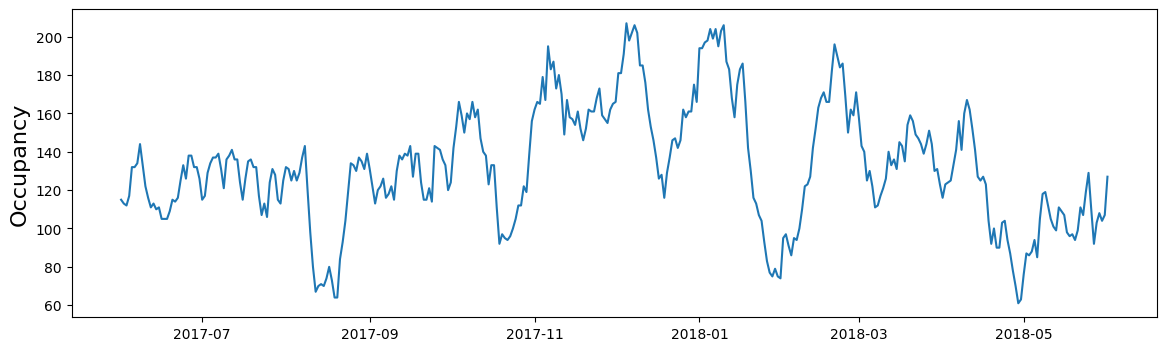

In [4]:
#plot
plt.figure(figsize=(14,4))
plt.plot(df)
plt.ylabel('Occupancy', fontsize=16)

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

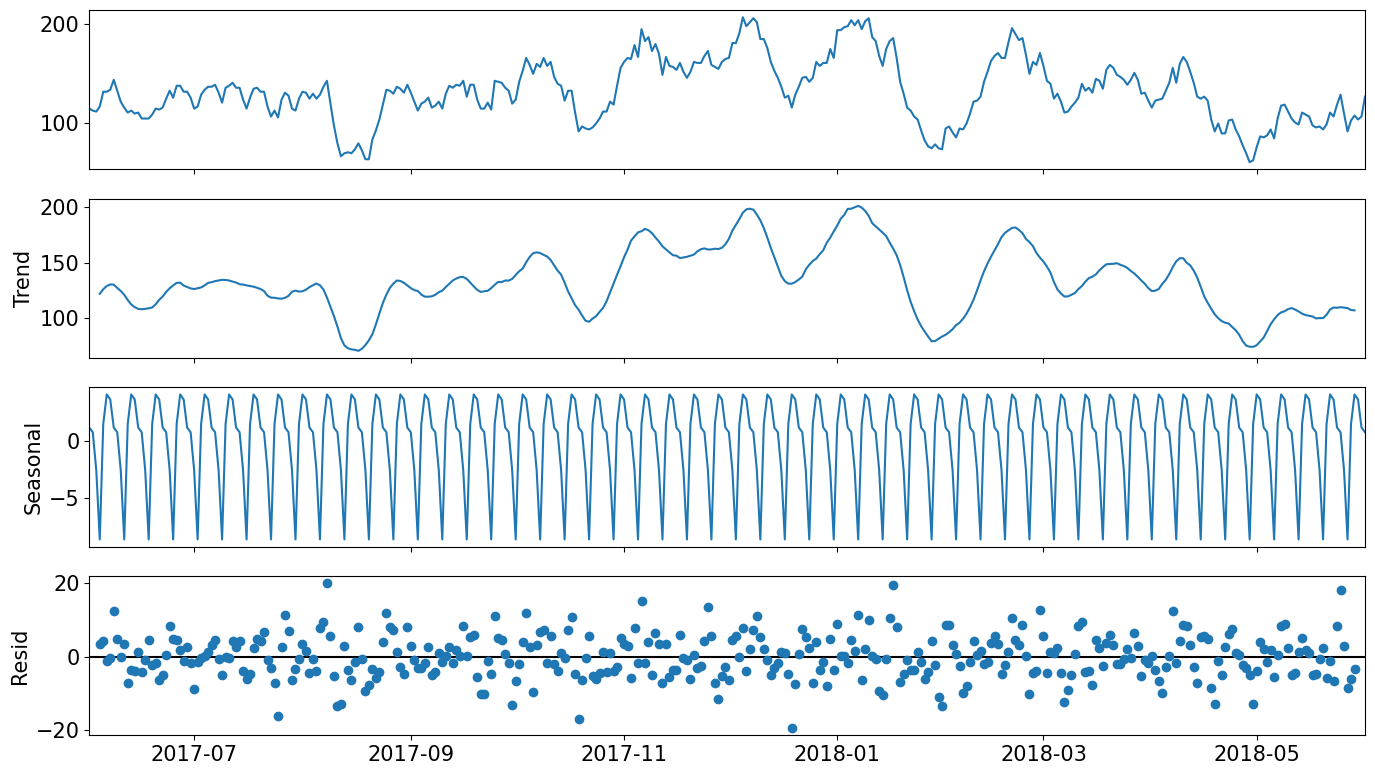

In [8]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df,model='additive')
fig = result.plot()

In [10]:
import pymannkendall as mk

In [11]:
print(mk.original_test(df, alpha=0.05))

Mann_Kendall_Test(trend='no trend', h=False, p=0.6509637731196751, z=0.4524237047963742, Tau=0.015854480125757915, s=1059.0, var_s=5468656.333333333, slope=0.006734006734006734, intercept=129.77104377104376)


In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

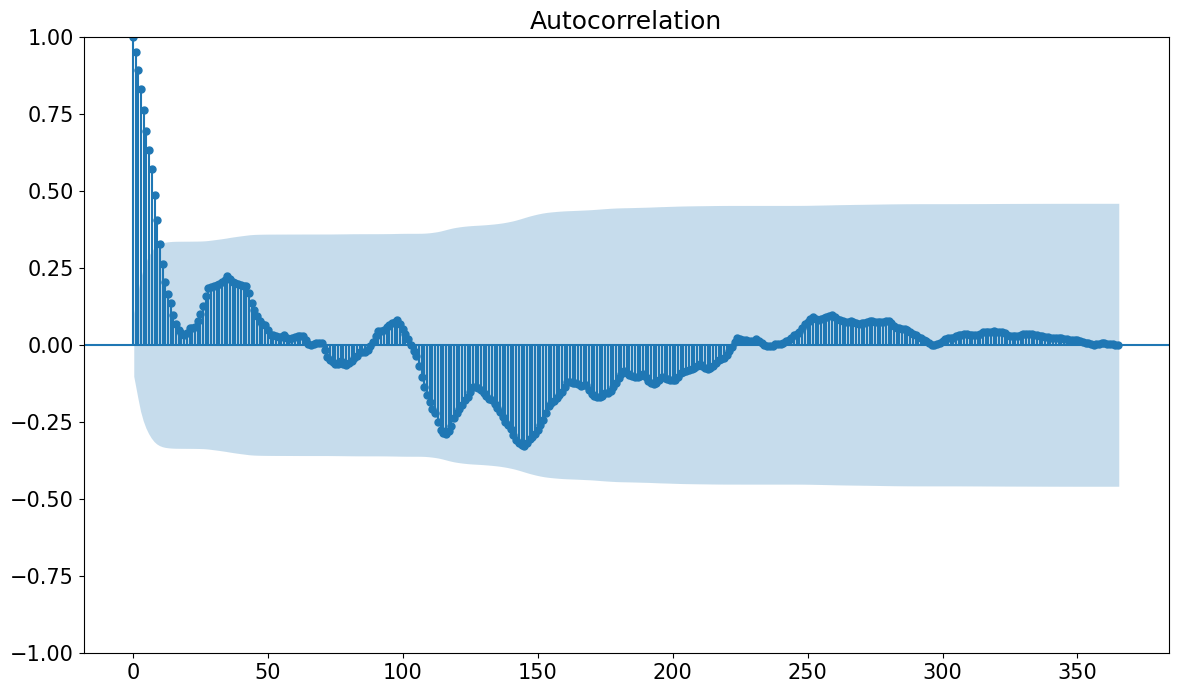

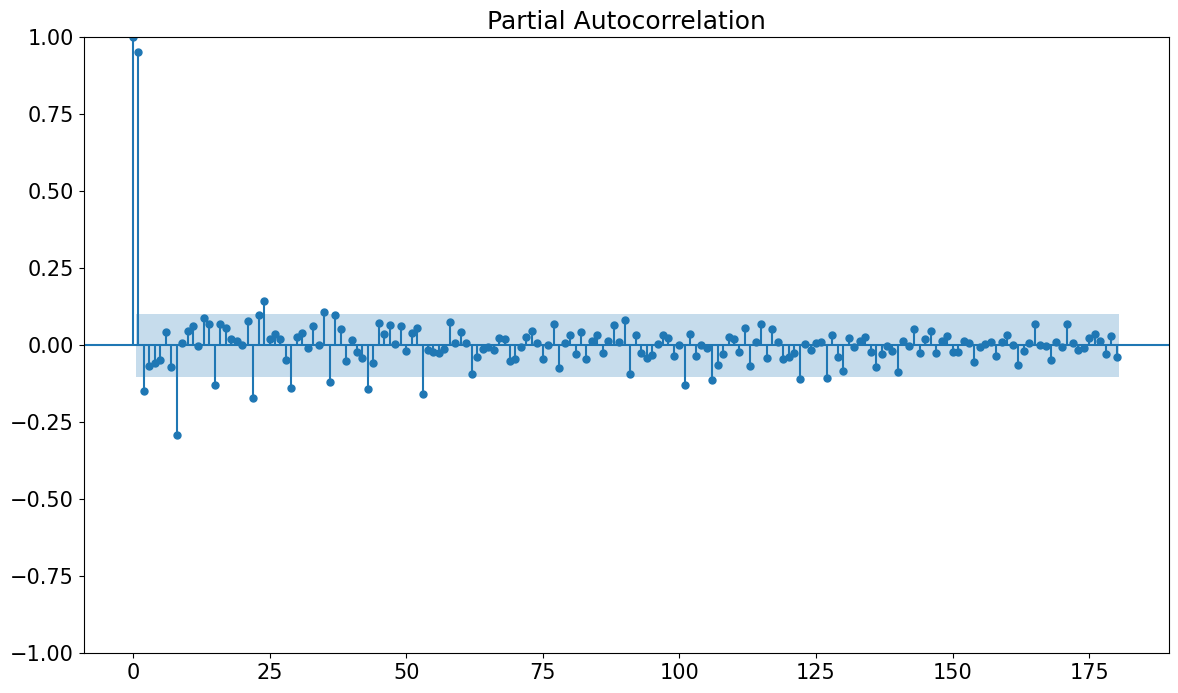

In [13]:
plot_acf(df['occupancy'], lags=365); # yearly pattern expected
plot_pacf(df['occupancy'], lags=180); # 300 because max value is 50% of data set

# No trend visible?
# Help: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
# dickey-fuller test
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['occupancy'])

The series is stationary


In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
#p, d, q = 50, 0, 1# 50 because some form of trend, 0 because data is stationary?, q=10?? results in a maximum likelihood error
p, d, q = 7, 0, 1# 7 because of PACF, 0 because data is stationary?, q=10?? results in a maximum likelihood error

arima = ARIMA(df['occupancy'], order=(p,d,q)) 
model_fit = arima.fit()
predictions = arima.fit().predict()

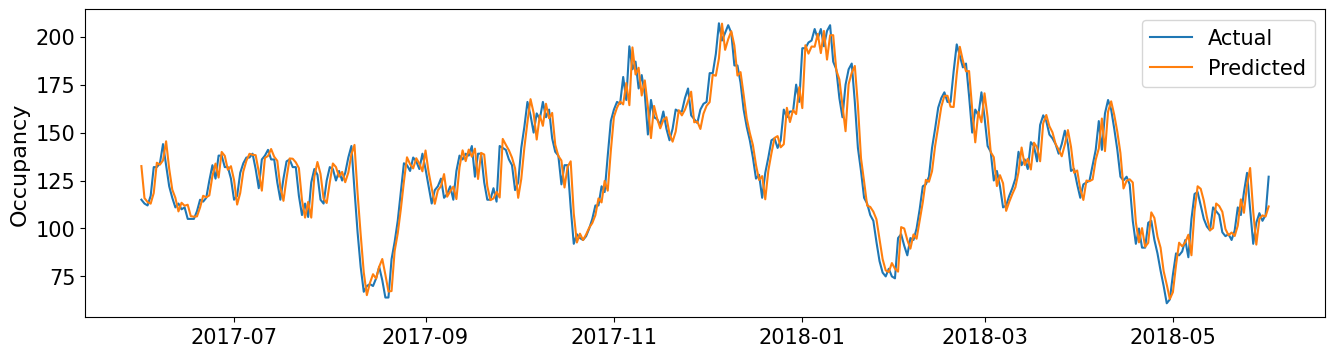

In [18]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [21]:
mse = mean_squared_error(df, predictions)
rmse = root_mean_squared_error(df, predictions)
mape = mean_absolute_percentage_error(df, predictions)
[mse, rmse, mape]

[85.454873090365, 9.244180498582068, 0.05816241204169352]

In [22]:
# Generate forecasts for the next 10 time steps
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps) # 30 days into the future

forecast_index = pd.date_range(start=predictions.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame({'dates': forecast_index, 'predicted_mean': forecast})

# Combine the predictions and forecasted values into a single DataFrame
prediction_forecast = pd.concat([predictions, forecast_df.set_index('dates')], axis=0)
prediction_forecast

,predicted_mean
dates,
2017-06-01,132.531041
2017-06-02,115.843319
2017-06-03,113.783595
2017-06-04,112.933521
2017-06-05,118.487344
...,...
2018-06-27,132.551310
2018-06-28,132.551066
2018-06-29,132.547017


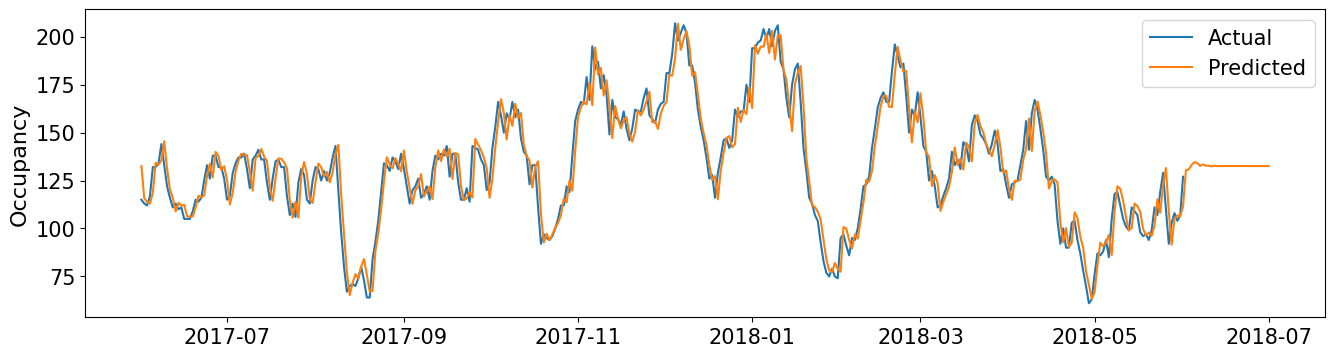

In [23]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(prediction_forecast, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [25]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
# SARIMA

sarima = SARIMAX(df['occupancy'],
                order=(1,0,1),
                seasonal_order=(1,0,1,7))
sarima_predictions = sarima.fit().predict()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22626D+00    |proj g|=  1.06823D+00


 This problem is unconstrained.



At iterate    5    f=  3.57708D+00    |proj g|=  1.64072D-02

At iterate   10    f=  3.56890D+00    |proj g|=  3.85578D-03

At iterate   15    f=  3.55831D+00    |proj g|=  7.93917D-03

At iterate   20    f=  3.55377D+00    |proj g|=  1.15706D-02

At iterate   25    f=  3.54763D+00    |proj g|=  7.92348D-04

At iterate   30    f=  3.54753D+00    |proj g|=  1.41026D-03

At iterate   35    f=  3.54721D+00    |proj g|=  6.38384D-04

At iterate   40    f=  3.54713D+00    |proj g|=  6.68926D-04

At iterate   45    f=  3.54711D+00    |proj g|=  4.45943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     70   

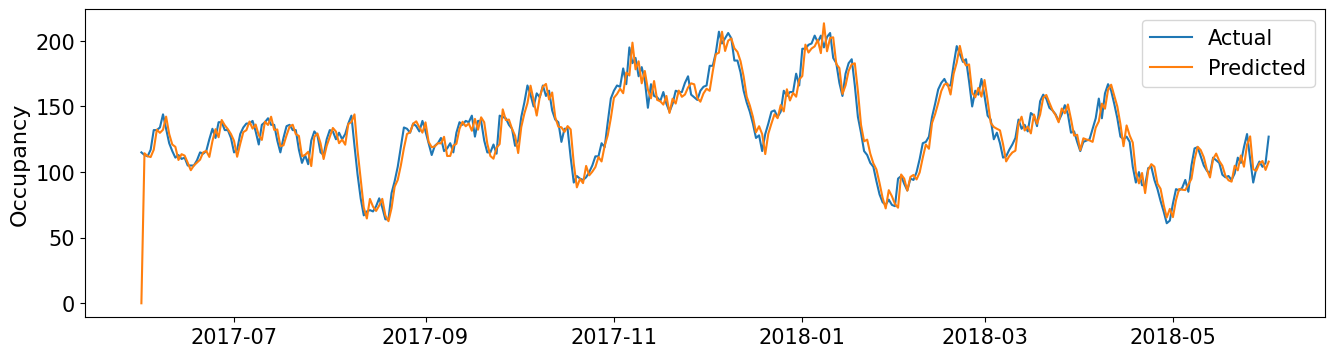

In [27]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(sarima_predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [28]:
mse = mean_squared_error(df, sarima_predictions)
rmse = root_mean_squared_error(df, sarima_predictions)
mape = mean_absolute_percentage_error(df, sarima_predictions)
[mse, rmse, mape]

[104.83390497986983, 10.238842951225974, 0.054800990454632825]

In [29]:
# Training

train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [30]:
#p, d, q = 50, 0, 1# 50 because some form of trend, 0 because data is stationary?, q=10??
p, d, q = 7, 0, 1# 7 because of PACF, 0 because data is stationary?, q=10?? results in a maximum likelihood error

arima_train_data = ARIMA(train_data['occupancy'], order=(p,d,q))
model_fit_train_data = arima_train_data.fit()

# Generate forecasts for the next 10 time steps
forecast_steps = 30
forecast_train_data = model_fit_train_data.forecast(steps=forecast_steps) # 30 days into the future

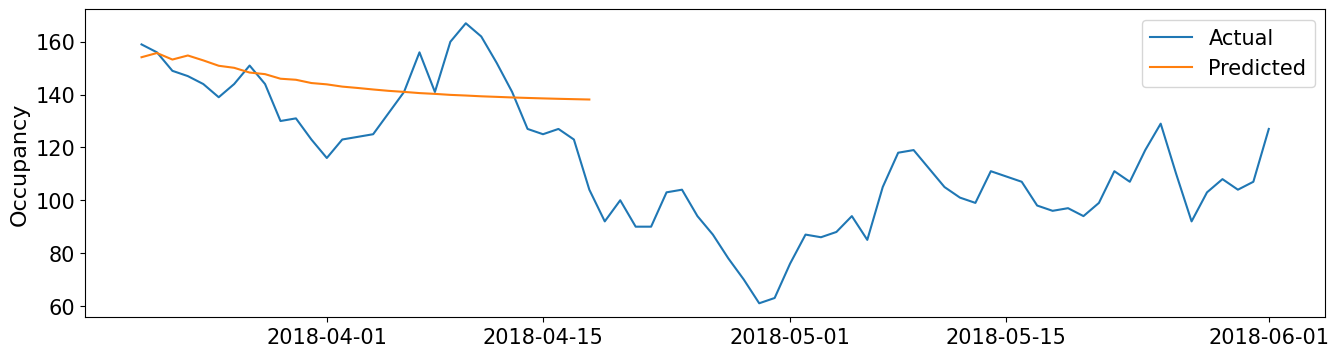

In [31]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [32]:
mse = mean_squared_error(test_data[:30], forecast_train_data)
rmse = root_mean_squared_error(test_data[:30], forecast_train_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[mse, rmse, mape]

[237.0967989823972, 15.397947882182132, 0.0961229422068527]

In [33]:
# Test until end of data
forecast_steps_whole_test_data = len(test_data)
forecast_train_data_whole_test_data = model_fit_train_data.forecast(steps=forecast_steps_whole_test_data) # 30 days into the future

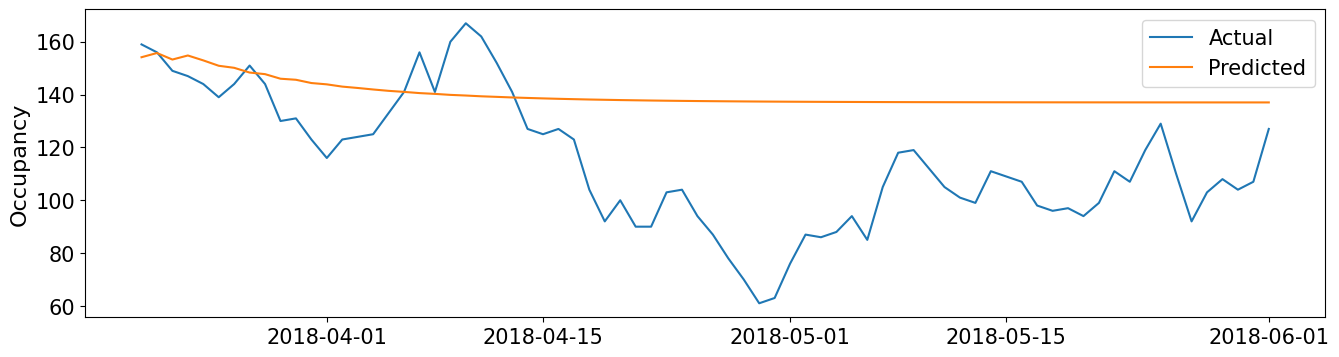

In [34]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data_whole_test_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [35]:
mse = mean_squared_error(test_data, forecast_train_data_whole_test_data)
rmse = root_mean_squared_error(test_data, forecast_train_data_whole_test_data)
mape = mean_absolute_percentage_error(test_data, forecast_train_data_whole_test_data)
[mse, rmse, mape]

[1119.8693675332304, 33.46444930868026, 0.29450168217500905]

In [37]:
# SARIMA

sarima = SARIMAX(train_data['occupancy'],
                order=(1,0,1),
                seasonal_order=(1,0,0,7))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94237D+00    |proj g|=  4.15505D-02

At iterate    5    f=  3.90376D+00    |proj g|=  1.19654D-02

At iterate   10    f=  3.65258D+00    |proj g|=  1.67432D-02

At iterate   15    f=  3.65244D+00    |proj g|=  3.68886D-04

At iterate   20    f=  3.65196D+00    |proj g|=  1.61295D-02

At iterate   25    f=  3.65135D+00    |proj g|=  7.53366D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   

 This problem is unconstrained.


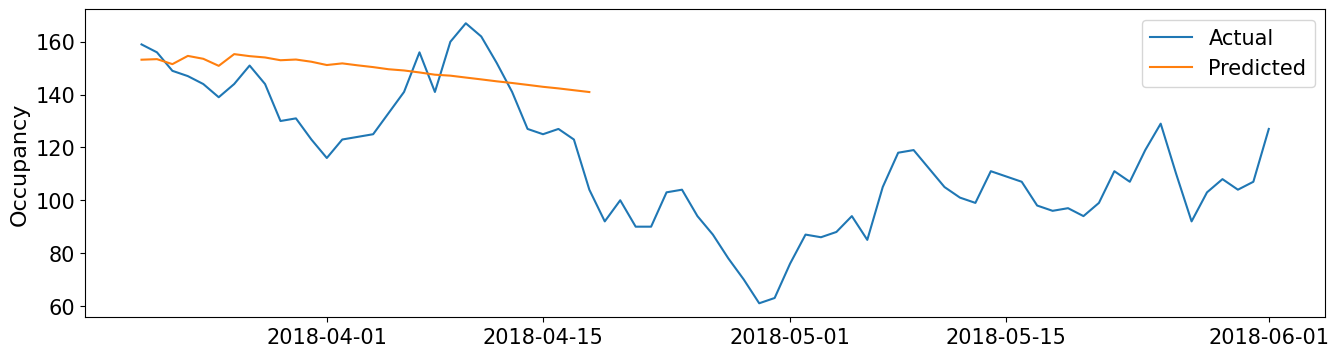

In [38]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [39]:
# Test until end of data
forecast_train_data_whole_test_data_sarima = model_fit_sarima.forecast(steps=forecast_steps_whole_test_data)

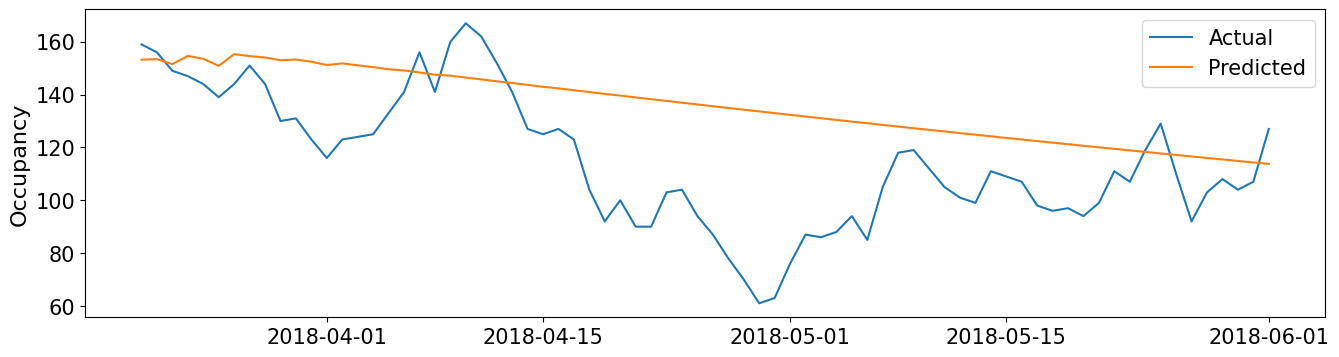

In [40]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data_whole_test_data_sarima, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()